In [49]:
from __future__ import print_function
from builtins import input

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco import util
from sporco import signal
from sporco import plot
plot.config_notebook_plotting()
from sporco.metric import psnr
from sporco.cupy import (cupy_enabled, np2cp, cp2np, select_device_by_load,
                         gpu_info)
from sporco.cupy.admm import cbpdn

In [50]:
def pad(x, n=8):

    if x.ndim == 2:
        return np.pad(x, n, mode='symmetric')
    else:
        return np.pad(x, ((n, n), (n, n), (0, 0)), mode='symmetric')


def crop(x, n=8):

    return x[n:-n, n:-n]

In [51]:
img = util.ExampleImages().image('e.jpg', zoom=0.5, scaled=True,
                                 idxexp=np.s_[:, :])
np.random.seed(12345)
imgn = signal.spnoise(img, 0.44)

In [52]:
D0 = util.convdicts()['RGB:8x8x3x64']
Di = np.zeros(D0.shape[0:2] + (3, 3), dtype=np.float32)
np.fill_diagonal(Di[0, 0], 1.0)
D = np.concatenate((Di, D0), axis=3)

In [53]:
lmbda = 3e0
mu = 2e1
w1 = np.ones((1, 1, 1, 1, D.shape[-1]), dtype=np.float32)
w1[..., 0:3] = 0.0
wg = np.zeros((D.shape[-1]), dtype=np.float32)
wg[..., 0:3] = 1.0

opt = cbpdn.ConvL1L1Grd.Options({'Verbose': True, 'MaxMainIter': 200,
                                'RelStopTol': 5e-3, 'AuxVarObj': False,
                                'rho': 4e1, 'RelaxParam': 1.8,
                                'L1Weight': np2cp(w1),
                                'GradWeight': np2cp(wg)})

In [54]:
if not cupy_enabled():
    print('CuPy/GPU device not available: running without GPU acceleration\n')
else:
    id = select_device_by_load()
    info = gpu_info()
    if info:
        print('Running on GPU %d (%s)\n' % (id, info[id].name))

b = cbpdn.ConvL1L1Grd(np2cp(D), np2cp(pad(imgn)), lmbda, mu, opt=opt, dimK=0)
X = cp2np(b.solve())

CuPy/GPU device not available: running without GPU acceleration

Itn   Fnc       DFid      Regℓ1     Regℓ2∇    r         s       
----------------------------------------------------------------
   0  2.98e+05  4.65e+04  7.40e+04  1.46e+03  4.42e-01  1.46e+00
   1  2.94e+05  5.77e+04  7.53e+04  5.17e+02  3.33e-01  1.62e+00
   2  2.61e+05  5.56e+04  6.72e+04  1.67e+02  2.54e-01  1.38e+00
   3  2.20e+05  5.64e+04  5.34e+04  1.79e+02  1.89e-01  1.76e+00
   4  1.97e+05  5.42e+04  4.71e+04  1.03e+02  1.46e-01  1.45e+00
   5  1.64e+05  5.47e+04  3.58e+04  1.20e+02  1.07e-01  1.84e+00
   6  1.46e+05  5.43e+04  3.00e+04  1.00e+02  8.41e-02  1.47e+00
   7  1.33e+05  5.45e+04  2.53e+04  1.05e+02  6.61e-02  1.69e+00
   8  1.17e+05  5.39e+04  2.04e+04  9.73e+01  5.24e-02  1.38e+00
   9  1.09e+05  5.38e+04  1.79e+04  9.62e+01  4.28e-02  1.70e+00
  10  9.84e+04  5.37e+04  1.43e+04  9.44e+01  3.53e-02  1.56e+00
  11  9.44e+04  5.37e+04  1.29e+04  9.13e+01  3.02e-02  1.65e+00
  12  8.95e+04  5.36e+04 

 124  5.65e+04  5.37e+04  5.30e+02  6.44e+01  4.59e-04  1.39e-01
 125  5.65e+04  5.37e+04  5.27e+02  6.44e+01  4.49e-04  1.37e-01
 126  5.65e+04  5.37e+04  5.23e+02  6.44e+01  4.40e-04  1.34e-01
 127  5.65e+04  5.37e+04  5.20e+02  6.44e+01  4.31e-04  1.32e-01
 128  5.65e+04  5.37e+04  5.17e+02  6.44e+01  4.22e-04  1.29e-01
 129  5.65e+04  5.37e+04  5.15e+02  6.44e+01  4.14e-04  1.26e-01
 130  5.65e+04  5.37e+04  5.12e+02  6.44e+01  4.06e-04  1.23e-01
 131  5.65e+04  5.37e+04  5.10e+02  6.44e+01  3.98e-04  1.20e-01
 132  5.65e+04  5.37e+04  5.07e+02  6.44e+01  3.91e-04  1.16e-01
 133  5.65e+04  5.37e+04  5.05e+02  6.44e+01  3.83e-04  1.13e-01
 134  5.65e+04  5.37e+04  5.03e+02  6.44e+01  3.76e-04  1.09e-01
 135  5.64e+04  5.37e+04  5.00e+02  6.44e+01  3.69e-04  1.06e-01
 136  5.64e+04  5.37e+04  4.98e+02  6.44e+01  3.62e-04  1.03e-01
 137  5.64e+04  5.37e+04  4.96e+02  6.44e+01  3.55e-04  1.00e-01
 138  5.64e+04  5.37e+04  4.93e+02  6.44e+01  3.48e-04  9.79e-02
 139  5.64e+04  5.37e+04 

In [55]:
imgdp = cp2np(b.reconstruct().squeeze())
imgd = crop(imgdp)

In [56]:
print("ConvL1L1Grd solve time: %5.2f s" % b.timer.elapsed('solve'))
print("Noisy image PSNR:    %5.2f dB" % psnr(img, imgn))
print("Denoised image PSNR: %5.2f dB" % psnr(img, imgd))

ConvL1L1Grd solve time: 2005.09 s
Noisy image PSNR:     7.69 dB
Denoised image PSNR: 31.37 dB


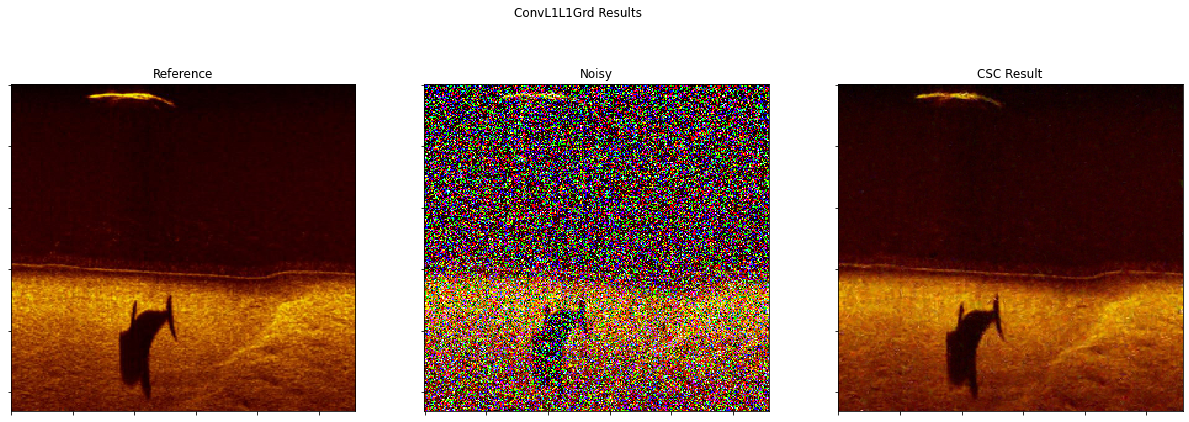

In [57]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(21, 7))
fig.suptitle('ConvL1L1Grd Results')
plot.imview(img, ax=ax[0], title='Reference', fig=fig)
plot.imview(imgn, ax=ax[1], title='Noisy', fig=fig)
plot.imview(imgd, ax=ax[2], title='CSC Result', fig=fig)
fig.show()

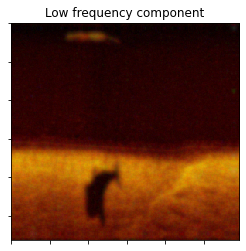

In [58]:
plot.imview(X[..., 0, 0:3].squeeze(), title='Low frequency component')

In [59]:
from skimage.metrics import structural_similarity as ssim
ssim_const_1 = ssim(img, imgd,
                  data_range=imgd.max() - imgd.min(), multichannel=True)

print(ssim_const_1)#structure similarity between two random variables -it measures contrast,variance,mean, luminous,covariance 

0.8241423464709857
